# DASi Submission

This notebook plans molecular biology assembly of new plasmids.

**Inputs**

* Session credentials (`config.toml`)
* Sequences at`output_plasmids/*.gb`

**Outputs**

* Inventory csv
* Selected Inventory csv
* Selected Inventory filter txt
* `design.out.json`

*Note: this script takes 10-25 minutes for ~32 plasmids. Please be patient.

In [9]:
# check versioning
import dasi
print(dasi.__version__)

import pyblast 
print(pyblast.cli.is_installed())

0.1.0
True


In [11]:
# login to Benchling & Aquarium
from aqbt.tools import config_to_sessions
from aqbt.tools import parse_config
import toml

def config(config_path):
    with open(config_path, "r") as f:
        return parse_config(toml.load(f))


def sessions(config):
    return config_to_sessions(config)


sessions = sessions(config('config.toml'))

benchling = sessions['default']['benchling']
registry = sessions['default']['registry']
session = sessions['default']['aquarium']

#### Load genbank files

There are the **new** sequences we aim to build.

In [12]:
from aqbt.bioadapter import convert
from aqbt import biopython
from glob import glob

records = biopython.load_genbank_glob(glob('output_plasmids/*.gb'))

### Collect Inventory

This is the **existing** inventory we have to build from. This is pulled from a semi-complicated script that connects Aquarium DB to Benchling DB and filters those sequences that exist as an item in Aquarium. This was saved as a `csv` file.

In [13]:
import pickle
from os.path import abspath
from os.path import dirname
from os.path import isfile
from os.path import join

from dasi import LibraryDesign

from aqbt.bioadapter import convert
from aqbt.design.dasi.dfs import KlavinsLabDnaDb


here = abspath(dirname("."))
DEFAULT_FILEPATH = join(here, "inventory.df")

from aqbt.design.dasi.dasi_to_aquarium import design_from_benchling_links, inventory_df

def inventory_df(registry=None, force_new: bool = False, filepath: str = None):
    if filepath is None:
        filepath = DEFAULT_FILEPATH
    df = None
    if isfile(filepath) and not force_new:
        with open(filepath, "rb") as f:
            try:
                return pickle.load(f)
            except Exception as e:
                print("Could not load pickled file.")
                print(e)
    if df is None:
        db = KlavinsLabDnaDb(registry)
        db.build(dna_limit=None, primer_limit=None)
        df = db.df[db.df["is_available"] == True]
        df.drop("benchling_sequence", axis=1, inplace=True)
        with open(filepath, "wb") as f:
            pickle.dump(df, f)

    # clean
    df["trashed"] = [s.name.lower().startswith("trashed") for s in df["sample"]]
    df = df[df["is_available"] == True]
    df = df[~df["trashed"]]
    return df

df = inventory_df(sessions['default']['registry'])

We do some additional filtering on the inventory database.

In [14]:
import json
import pandas as pd

filtered_rows = []

for _, row in df.iterrows():
    if not (row['sample_id'] < 20000 and \
            row['sample_type'] in ['Fragment', 'Plasmid']) and row['sample_id'] > 1000:
        filtered_rows.append(row)

df.to_csv("InventoryDataFrame.csv")
selected_df = pd.DataFrame(filtered_rows)
selected_df.to_csv("SelectedInventory.csv")

with open('SelectionInventoryFilter.txt', 'w') as f:
    f.write("""
# filter
for _, row in df.iterrows():
    if not (row['sample_id'] < 20000 and \
            row['sample_type'] in ['Fragment', 'Plasmid']) and row['sample_id'] > 1000:
        filtered_rows.append(row) 
""")

In [ ]:
# inv_df = dasi_df
# fragments = _get_records(inv_df, 'Fragment')
# plasmids = _get_records(inv_df, "Plasmid")
# primers = _get_records(inv_df, "Primer")

# biopython.make_linear(fragments)
# biopython.make_linear(primers)
# biopython.make_cyclic(plasmids)
# biopython.make_cyclic(records)

# from Bio.Alphabet import generic_dna

# def add_alphabet(recs):
#     for r in recs:
#         r.seq.alphabet = generic_dna
        
# add_alphabet(fragments + plasmids + primers + records)

# # save to github

# from os.path import join, abspath, dirname

# path = '/home/justin/Github/DASi-DNA-Design/tests/test_examples/fixtures/'

# from Bio import SeqIO


# SeqIO.write(fragments, join(path, 'fragments_0.gb'), format='genbank')
# SeqIO.write(plasmids, join(path, 'plasmids_0.gb'), format='genbank')
# SeqIO.write(primers, join(path, 'primers_0.gb'), format='genbank')
# SeqIO.write(records, join(path, 'goals_0.gb'), format='genbank')

## DASi Submission

### Prepare Inventory Dataframe

In [15]:
def _filter_available(df):
    return df[df['is_available'] == True]

def _get_records(df, st):
    return list(df[df["sample_type"] == st]["record"])

dasi_df = _filter_available(selected_df)

### Run test design

This may take a few minutes.

In [16]:
from Bio.SeqRecord import SeqRecord
from typing import List
from dasi import Design


def new_design(inv_df: pd.DataFrame, records: List[SeqRecord], 
               favor_shared_sequences: int = 2.0, 
               log_level='ERROR'):
    fragments = _get_records(inv_df, 'Fragment')
    plasmids = _get_records(inv_df, "Plasmid")
    primers = _get_records(inv_df, "Primer")

    biopython.make_cyclic(records)
    biopython.make_linear(fragments)
    biopython.make_linear(primers)
    biopython.make_linear(plasmids)
    
    design = LibraryDesign()
    design.FAVOR_SHARED_SEQUENCES = favor_shared_sequences
    design.add_materials(
        primers=primers, fragments=fragments, templates=plasmids, queries=records
    )
    design.logger.set_level(log_level)
    return design

def run_design(inv_df: pd.DataFrame, records: List[SeqRecord], 
               favor_shared_sequences: int = 2.0, 
               log_level='ERROR', 
               n_jobs: int = 6):
    
    design = new_design(inv_df, records, favor_shared_sequences, log_level)
    design.pooled_run(16, 1)
    return design

In [18]:
from dasi.config import Config

Config.SequenceScoringConfig.post_process_stages = ('SCORE_COMPLEXITY',
 'SCORE_LONG_PCR_PRODUCTS',
 'SCORE_MISPRIMINGS', Config.SequenceScoringConfig.PARTITION)

Config.SequenceScoringConfig.post_process_stages

from dasi.design.graph_builder import SequenceScoringConfig

SequenceScoringConfig.edge_threshold = 0.000001

design = new_design(dasi_df, records, log_level='INFO')
design.run(n_jobs=6)

  0%|          | 0/5 [00:00<?, ?it/s]

INFO - ProgressLoggable(LibraryDesign(id=139823003969760)) - 2020-07-30 11:33:21,099 - Running blast


  0%|          | 0/5 [00:02<?, ?it/s]

INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:23,513 - Number of template matches: 9622


  0%|          | 0/5 [00:03<?, ?it/s]

INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:24,787 - Number of perfect fragment matches: 64


  0%|          | 0/5 [00:09<?, ?it/s]

INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:30,488 - Number of perfect primers: 2842


 20%|██        | 1/5 [00:09<00:38,  9.60s/it]

INFO - ProgressLoggable(LibraryDesign(id=139823003969760)) - 2020-07-30 11:33:30,698 - Running shared fragment blast
INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:30,702 - === Expanding shared library fragments ===


 20%|██        | 1/5 [00:12<00:38,  9.60s/it]

INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:33,355 - Found 6272 shared alignments between the queries


 20%|██        | 1/5 [00:12<00:38,  9.60s/it]

INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:33,892 - baabe288-8fca-4274-af42-b85684d9ac09: Expanded PCR_PRODUCT using SHARED_SYNTHESIZED_FRAGMENT and found 0 new alignments.
INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:33,900 - ced4fcbc-c71a-4a25-bca7-9c8719400c05: Expanded PCR_PRODUCT using SHARED_SYNTHESIZED_FRAGMENT and found 0 new alignments.
INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:33,910 - f6a9746b-1730-42a3-9dba-f8848a656ae9: Expanded PCR_PRODUCT using SHARED_SYNTHESIZED_FRAGMENT and found 0 new alignments.
INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:33,918 - 685fb20f-a1a9-4e0c-a974-3ce02bcc8f66: Expanded PCR_PRODUCT using SHARED_SYNTHESIZED_FRAGMENT and found 0 new alignments.
INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:33,924 - e98db1ea-d74e-4c7d-875a-c317b45c9734: Expanded PCR_PRODUCT using SHARED_SYNTHESIZED_FRAGMENT and found 0 new alignments.
INFO - LibraryDesign(id=139823003969760) - 2020-07

 80%|████████  | 4/5 [00:13<00:07,  7.06s/it]

INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:34,095 - 29786f88-8e96-46ff-b35b-3d890f2a5613: Expanded PCR_PRODUCT using SHARED_SYNTHESIZED_FRAGMENT and found 0 new alignments.
INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:34,102 - c04f5ad4-8e78-4bf7-a534-a2e140977a0a: Expanded PCR_PRODUCT using SHARED_SYNTHESIZED_FRAGMENT and found 0 new alignments.
INFO - LibraryDesign(id=139823003969760) - 2020-07-30 11:33:34,108 - 5f2e56d5-105c-44ae-b4c9-7106faa9bc40: Expanded PCR_PRODUCT using SHARED_SYNTHESIZED_FRAGMENT and found 0 new alignments.
INFO - ProgressLoggable(LibraryDesign(id=139823003969760)) - 2020-07-30 11:33:34,109 - Finding shared clusters


 80%|████████  | 4/5 [01:44<00:26, 26.07s/it]

{'eee0ed16-4c1d-44fe-b56d-9a7008a71396': [(5078, 5152)], 'b9f8c612-5aff-47ec-846b-f8d39b12c9a1': [(4897, 4971)], '10d49969-37c3-4723-9dbd-94bcae770be8': [(5078, 5152)], '603ec206-6296-4b99-bdd7-c3d1ee869438': [(4897, 4971)], '7ceacbf9-bb61-454d-9006-67e70ca6758d': [(4897, 4971), (4969, 5043)], 'b3bdfd52-a4f1-44fd-97df-7514bcc279f3': [(5078, 5152)], 'ce355ef4-d191-4bfb-b248-3ea687c79d34': [(5078, 5152), (5150, 5224)], 'baabe288-8fca-4274-af42-b85684d9ac09': [(4897, 4971)]}
{'10d49969-37c3-4723-9dbd-94bcae770be8': [(4722, 4753), (4686, 4717)], 'b3bdfd52-a4f1-44fd-97df-7514bcc279f3': [(4686, 4717), (4722, 4753)], 'ce355ef4-d191-4bfb-b248-3ea687c79d34': [(4686, 4717), (4722, 4753)], 'eee0ed16-4c1d-44fe-b56d-9a7008a71396': [(4686, 4717), (4722, 4753)]}
{'10d49969-37c3-4723-9dbd-94bcae770be8': [(4651, 4686), (4686, 4721)], 'eee0ed16-4c1d-44fe-b56d-9a7008a71396': [(4651, 4686), (4686, 4721)], 'ce355ef4-d191-4bfb-b248-3ea687c79d34': [(4651, 4686), (4686, 4721)], 'b3bdfd52-a4f1-44fd-97df-7514bc


/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/utils/sequence/sequence_partitioner.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif j == "STOP":
/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/utils/sequence/sequence_partitioner.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i == "STOP":
/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/utils/sequence/sequence_partitioner.py:24: FutureWarning: elementwise comp

In [21]:
out = design.out(elim_extra_reactions=True)

#### Plot Results

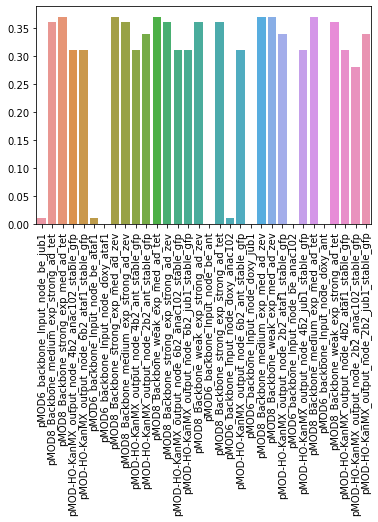

In [78]:
import seaborn as sns
import pylab as plt

def get(d, keys):
    v = d
    for k in keys:
        
        v = v[k]
    return v

def plot_results(out, design, keys):
    x = []
    y = []
    default = 0.
    for k, d in out['designs'].items():
        seq = design.seqdb[k]
        x.append(seq.name)
        if d['assemblies']:
            a = d['assemblies'][0]
            y.append(get(a, keys))
        else:
            y.append(default)
    return x, y

def plot_complexity(out, design,):
    plt.xticks(rotation=90)
    x, y = plot_results(out, design, ('cost', 'max synthesis complexity'))
    sns.barplot(x, y)

def plot_efficiency(out, design):
    plt.xticks(rotation=90)
    x, y = plot_results(out, design, ('cost', 'assembly efficiency'))
    sns.barplot(x, y)
    
# plot_complexity(out, design)
# plt.show()
plot_efficiency(out, design)

In [ ]:
passable_query_keys = []

x, y = plot_results(out, design, ('cost', 'max synthesis complexity'))
z = list(zip(x, y))
z = [_z[0] for _z in z if _z[1] < 10.]

['pMOD6_backbone_Input_node_be_jub1',
 'pMOD8_Backbone_medium_exp_strong_ad_tet',
 'pMOD8_Backbone_strong_exp_med_ad_tet',
 'pMOD-HO-KanMX_output_node_4b2_anac102_stable_gfp',
 'pMOD-HO-KanMX_output_node_6b2_ataf1_stable_gfp',
 'pMOD6_backbone_Input_node_be_ataf1',
 'pMOD6_backbone_Input_node_doxy_ataf1',
 'pMOD8_Backbone_strong_exp_med_ad_zev',
 'pMOD8_Backbone_medium_exp_strong_ad_zev',
 'pMOD-HO-KanMX_output_node_4b2_ant_stable_gfp',
 'pMOD-HO-KanMX_output_node_2b2_ant_stable_gfp',
 'pMOD8_Backbone_weak_exp_med_ad_tet',
 'pMOD8_Backbone_strong_exp_strong_ad_zev',
 'pMOD-HO-KanMX_output_node_6b2_anac102_stable_gfp',
 'pMOD-HO-KanMX_output_node_6b2_jub1_stable_gfp',
 'pMOD8_Backbone_weak_exp_strong_ad_zev',
 'pMOD6_backbone_Input_node_be_ant',
 'pMOD8_Backbone_strong_exp_strong_ad_tet',
 'pMOD6_backbone_Input_node_doxy_anac102',
 'pMOD-HO-KanMX_output_node_6b2_ant_stable_gfp',
 'pMOD6_backbone_Input_node_doxy_jub1',
 'pMOD8_Backbone_medium_exp_med_ad_zev',
 'pMOD8_Backbone_weak_exp_me

In [18]:
# record = records[0]
# import webbrowser

# def to_benchling(record, folder_id):
#     data = convert(record, to="benchling_dna_json")
#     data['folder_id'] = folder_id
#     seq = benchling.DNASequence.load(data)
#     return seq

# def dna_open(record, folder_name='APITrash'):
#     seq = to_benchling(record, benchling.Folder.find_by_name('APITrash').id)
#     seq.save()
#     url = 'http://www.benchling.com' + seq.url
#     print(url)
#     webbrowser.open(url)
    
# dna_open(record)

http://www.benchling.com/jvrana/f/lib_SjLcTsG4-apitrash/seq_khozsStE-pmod6_backbone_input_node_be_jub1/edit


In [22]:
# trash_folder = benchling.Folder.find_by_name("APITrash")

# from aqbt.bioadapter import convert

# data = convert(records[0], to="benchling_dna_json", benchling_session=benchling, folder_id=trash_folder.id)
# data['folder_id'] = trash_folder.id
# seq = benchling.DNASequence.load(data)
# seq.save()
# print(seq.url)

/jvrana/f/lib_SjLcTsG4-apitrash/seq_rZilO9j6-pmod6_backbone_input_node_be_jub1/edit


### Output design

In [84]:
df1, df2, file_location_json = design.to_df()

with open('design_files.json', 'w') as f:
    json.dump(file_location_json, f)
    
df1.to_csv("design_info_1.csv")
df2.to_csv("design_info_2.csv")

# save output 
json_output = design.out(elim_extra_reactions=True)
with open('design.out.json', 'w') as f:
    json.dump(json_output, f, indent=2)

ERROR - LibraryDesign(id=139823003969760) - 2020-07-30 12:06:27,646 - Query pMOD6_backbone_Input_node_be_ant 16 yielded no assembly
ERROR - LibraryDesign(id=139823003969760) - 2020-07-30 12:06:27,699 - Query pMOD6_backbone_Input_node_be_anac102 24 yielded no assembly


##### Report